# Convolutional Neural Network with Grad-CAM

Bu notebook'ta bir CNN modeli eğitip, Grad-CAM ile modelin hangi bölgelere odaklandığını inceleyeceğiz.

Kütüphaneleri eklemekle başlayalım.

In [62]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Basit bir veri seti yükleme ve görselleştirme
from sklearn.datasets import make_moons

## Veri Seti

Basit bir örnek veri seti (make_moons) kullanıyoruz. Amaç veri dağılımını görselleştirmek.

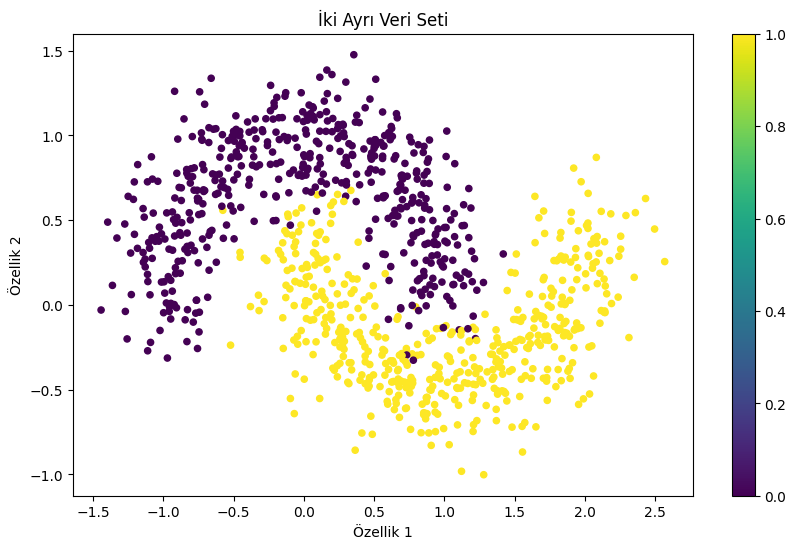

In [63]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
plt.title('İki Ayrı Veri Seti')
plt.xlabel('Özellik 1')
plt.ylabel('Özellik 2')
plt.colorbar()
plt.show()

## Veri Önişleme

- Eğitim verisi normalize ediliyor ve çeşitli augmentasyonlar uygulanıyor.
- Test verisi sadece normalize ediliyor.

In [64]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

training_set = train_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/test_set/test_set',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## CNN Modeli

- Model 2 Conv katmanı, MaxPooling, Flatten, Dense ve Dropout içeriyor.
- Çıkış katmanı binary sınıflandırma için sigmoid aktivasyonu kullanıyor.


In [65]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.4))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Eğitimi

- Model 'adam' optimizer ve 'binary_crossentropy' loss ile 50 epoch boyunca eğitiliyor.
- Eğitim ve doğrulama (validation) accuracy/loss grafikleri ile takip ediliyor.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.5157 - loss: 0.6962 - val_accuracy: 0.5645 - val_loss: 0.6813
Epoch 2/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.5801 - loss: 0.6778 - val_accuracy: 0.6026 - val_loss: 0.6555
Epoch 3/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.6092 - loss: 0.6611 - val_accuracy: 0.6733 - val_loss: 0.6163
Epoch 4/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.6314 - loss: 0.6472 - val_accuracy: 0.6886 - val_loss: 0.5983
Epoch 5/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.6507 - loss: 0.6269 - val_accuracy: 0.6911 - val_loss: 0.5902
Epoch 6/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.6637 - loss: 0.6235 - val_accuracy: 0.6950 - val_loss: 0.5778
Epoch 7/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.6717 - loss: 0.6065 - val_accuracy: 0.7000 - val_loss: 0.5692
Epoch 8/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.6728 - loss: 0.6006 - 

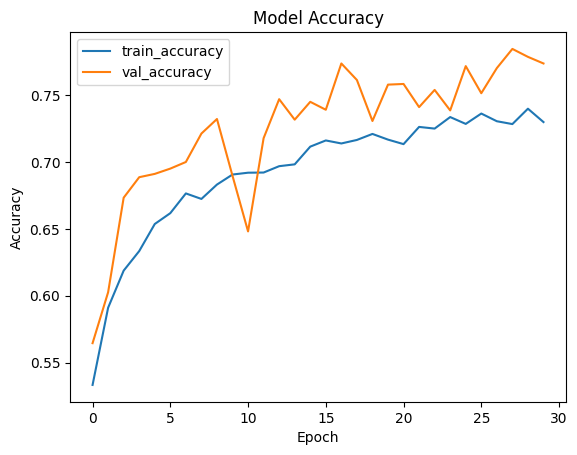

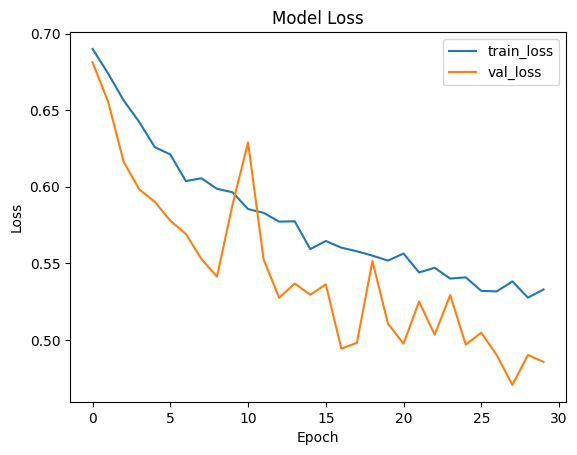

In [66]:
# Compiling the CNN
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
history = cnn.fit(x=training_set, validation_data=test_set, epochs=30)

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Değerlendirme

- Confusion matrix ve classification report ile model performansı analiz ediliyor.


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


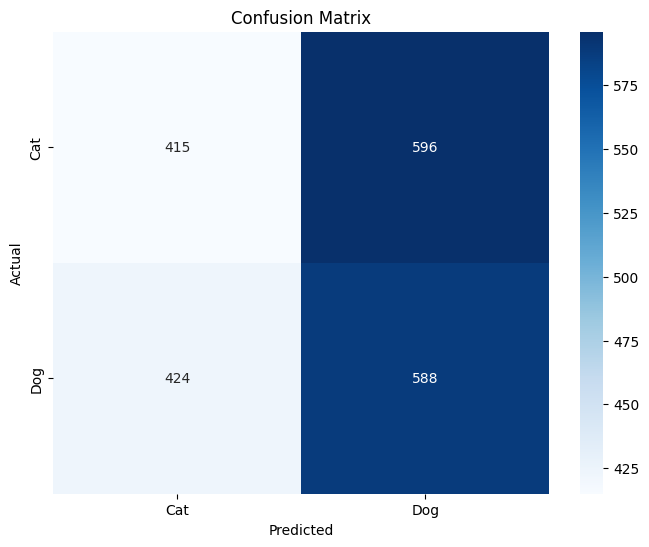


Classification Report:
              precision    recall  f1-score   support

         Cat       0.49      0.41      0.45      1011
         Dog       0.50      0.58      0.54      1012

    accuracy                           0.50      2023
   macro avg       0.50      0.50      0.49      2023
weighted avg       0.50      0.50      0.49      2023



In [67]:
predictions = cnn.predict(test_set)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_set.classes
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], 
            yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
report = classification_report(true_classes, predicted_classes, 
                             target_names=['Cat', 'Dog'])
print(report)

## Grad-CAM

- Modelin tahminlerini hangi bölgelere odaklanarak yaptığı görselleştiriliyor.
- Sarı/kırmızı bölgeler modelin ilgilendiği alanları gösteriyor.
- Başlık rengi: yeşil = doğru tahmin, kırmızı = yanlış tahmin.


GRAD-CAM ANALİZİ

 Model Mimarisi:
 0: conv2d_20       (Conv2D)
 1: max_pooling2d_20 (MaxPooling2D)
 2: conv2d_21       (Conv2D)
 3: max_pooling2d_21 (MaxPooling2D)
 4: flatten_10      (Flatten)
 5: dense_20        (Dense)
 6: dropout_10      (Dropout)
 7: dense_21        (Dense)
Grad-CAM Başlıyor...
Örnek 1/6 işleniyor...
Bulunan Conv katmanları: ['conv2d_20', 'conv2d_21']
Kullanılan katman: conv2d_21
Grad-CAM hatası: The layer sequential_10 has never been called and thus has no defined output.
Örnek 2/6 işleniyor...
Bulunan Conv katmanları: ['conv2d_20', 'conv2d_21']
Kullanılan katman: conv2d_21
Grad-CAM hatası: The layer sequential_10 has never been called and thus has no defined output.
Örnek 3/6 işleniyor...
Bulunan Conv katmanları: ['conv2d_20', 'conv2d_21']
Kullanılan katman: conv2d_21
Grad-CAM hatası: The layer sequential_10 has never been called and thus has no defined output.
Örnek 4/6 işleniyor...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_370']
Received: inputs=Tensor(shape=(1, 64, 64, 3))
  warnings.warn(msg)


Bulunan Conv katmanları: ['conv2d_20', 'conv2d_21']
Kullanılan katman: conv2d_21
Grad-CAM hatası: The layer sequential_10 has never been called and thus has no defined output.
Örnek 5/6 işleniyor...
Bulunan Conv katmanları: ['conv2d_20', 'conv2d_21']
Kullanılan katman: conv2d_21
Grad-CAM hatası: The layer sequential_10 has never been called and thus has no defined output.
Örnek 6/6 işleniyor...
Bulunan Conv katmanları: ['conv2d_20', 'conv2d_21']
Kullanılan katman: conv2d_21
Grad-CAM hatası: The layer sequential_10 has never been called and thus has no defined output.


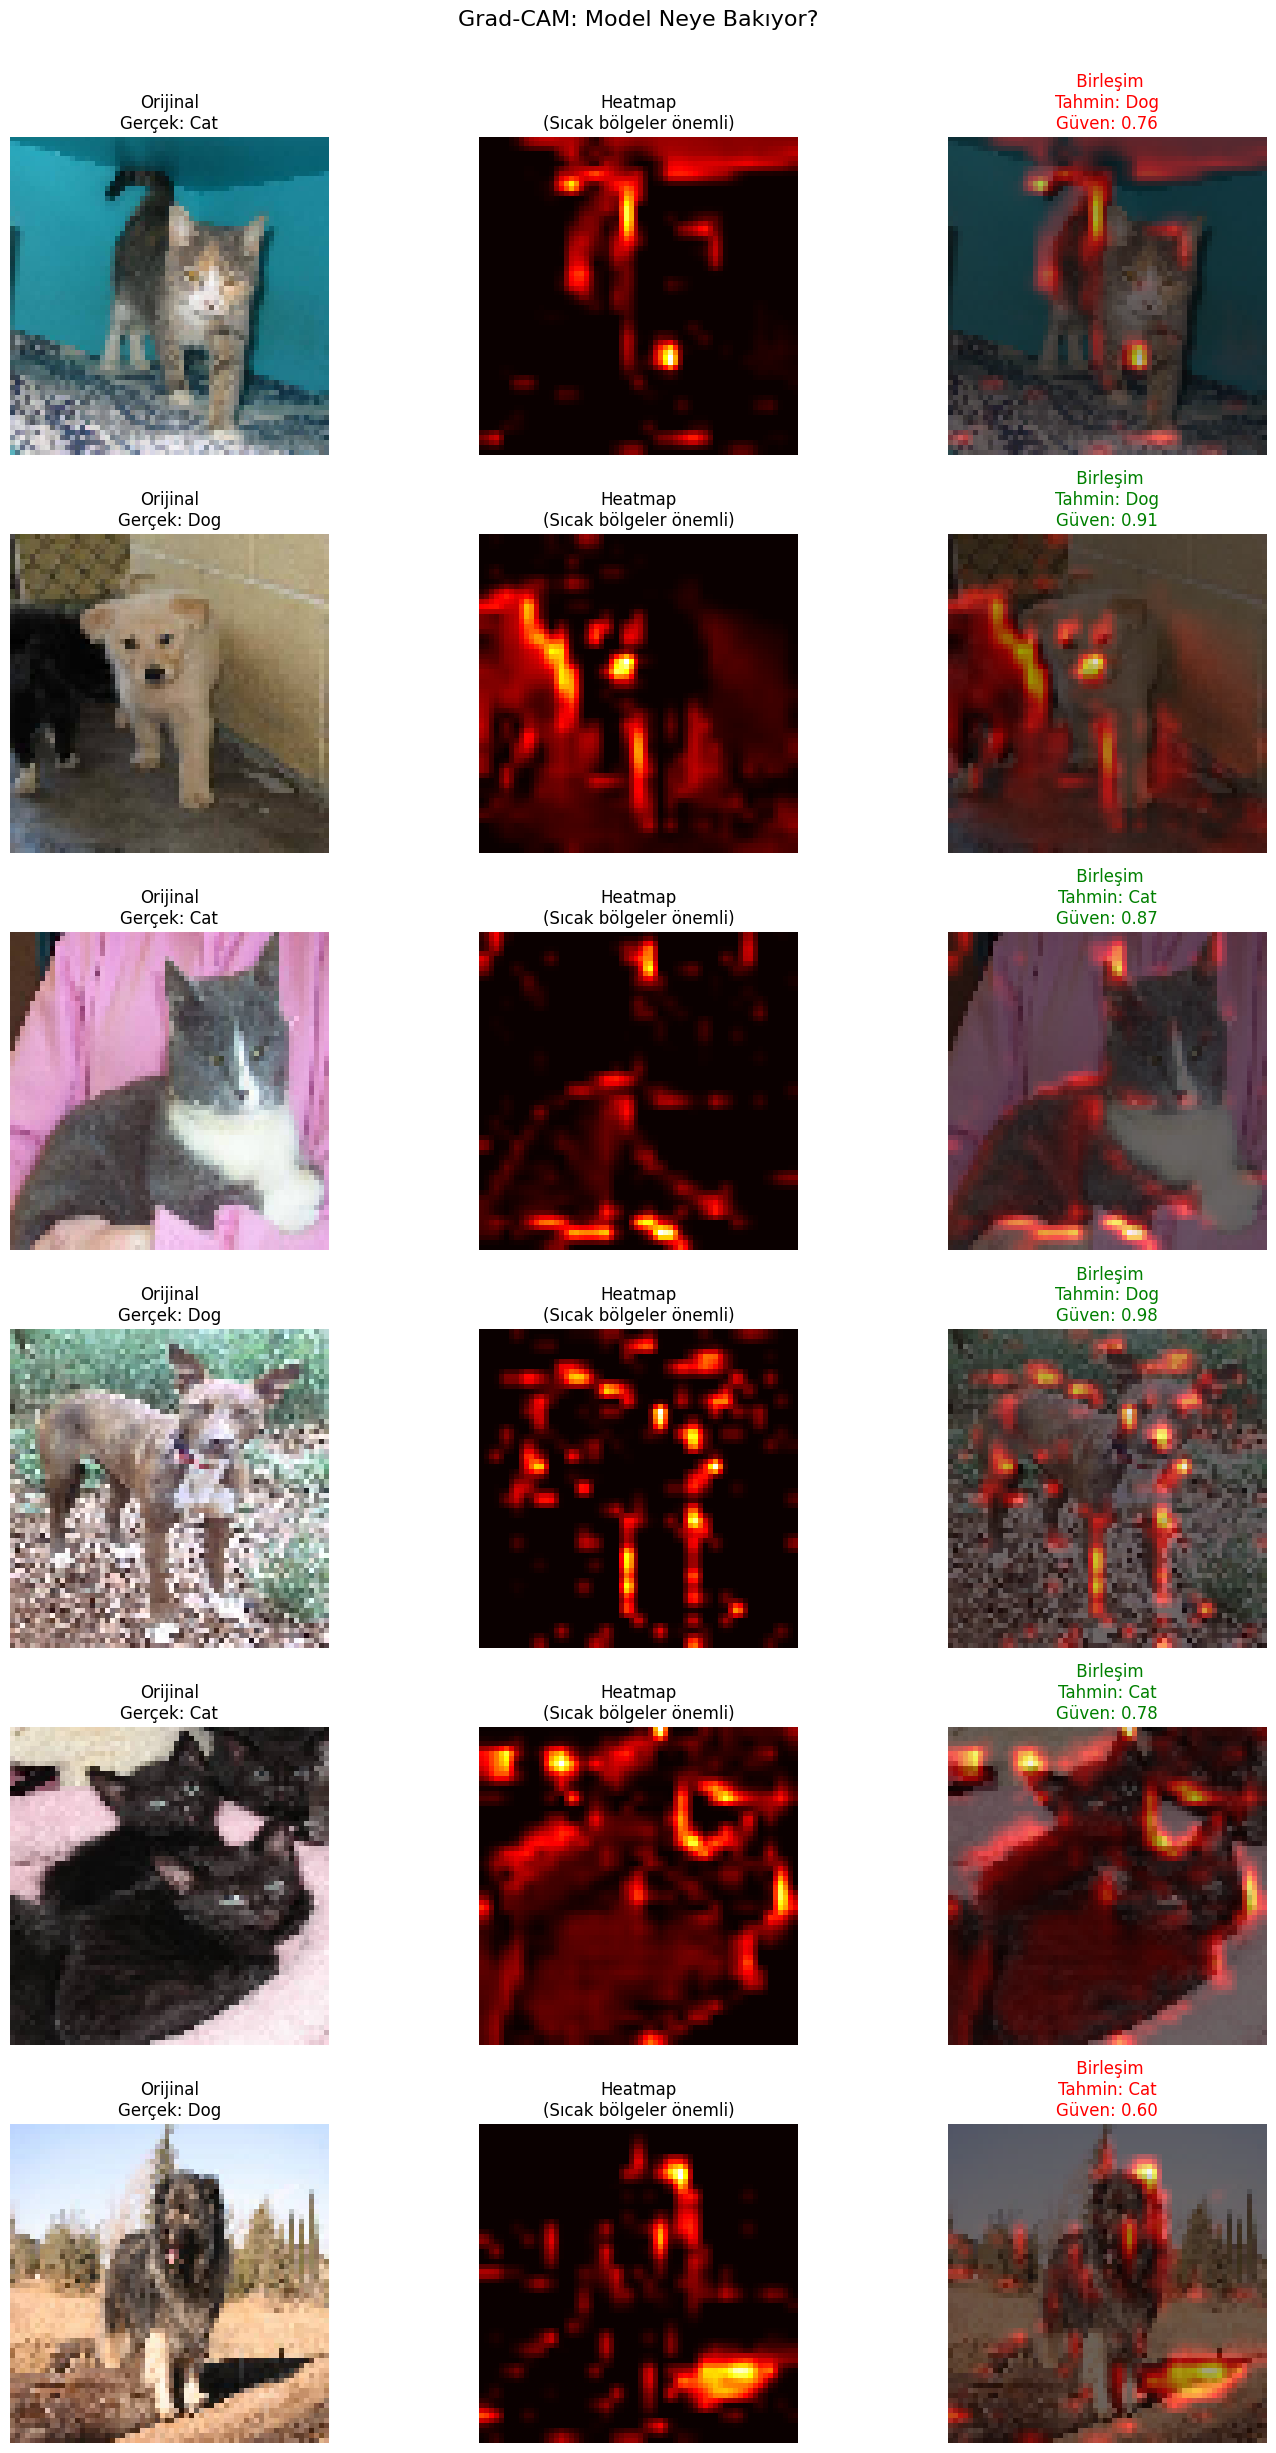

Grad-CAM tamamlandı!

Açıklama:
Sarı/Kırmızı bölgeler: Model bu bölgelere çok odaklanıyor
Yeşil başlık: Doğru tahmin
Kırmızı başlık: Yanlış tahmin


In [68]:
def get_conv_layer_names(model):
    
    conv_layers = []
    for layer in model.layers:
        if 'conv2d' in layer.name:
            conv_layers.append(layer.name)
    return conv_layers

def gradcam(model, image):
   
    
    # Conv katmanlarını bul
    conv_layers = get_conv_layer_names(model)
    print(f"Bulunan Conv katmanları: {conv_layers}")
    
    if not conv_layers:
        print("Conv katmanı bulunamadı!")
        return np.random.rand(16, 16)  # Rastgele heatmap döndür
    
    # En son conv katmanını kullan
    target_layer = conv_layers[-1]
    print(f"Kullanılan katman: {target_layer}")
    
    try:
        # Grad-CAM modeli oluştur
        grad_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[model.get_layer(target_layer).output, model.output]
        )
        
        # Gradientleri hesapla
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(image)
            loss = predictions[:, 0]
        
        # Gradientler
        grads = tape.gradient(loss, conv_outputs)
        
        if grads is None:
            print("Gradientler None, basit activation map kullanılıyor...")
           
            conv_output = conv_outputs[0]
            heatmap = tf.reduce_mean(conv_output, axis=-1)
        else:
            
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_output = conv_outputs[0]
            heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1)
        
        
        heatmap = tf.maximum(heatmap, 0)
        max_val = tf.reduce_max(heatmap)
        if max_val > 0:
            heatmap = heatmap / max_val
        
        return heatmap.numpy()
        
    except Exception as e:
        print(f"Grad-CAM hatası: {e}")
        
        
        # En basit fallback: sadece conv katmanı çıktısını al
        try:
            conv_model = tf.keras.models.Model(
                inputs=model.inputs,
                outputs=model.get_layer(target_layer).output
            )
            conv_output = conv_model(image)[0]
            heatmap = tf.reduce_mean(conv_output, axis=-1)
            heatmap = tf.maximum(heatmap, 0)
            max_val = tf.reduce_max(heatmap)
            if max_val > 0:
                heatmap = heatmap / max_val
            return heatmap.numpy()
        except:
            print("Rastgele heatmap oluşturuluyor...")
            return np.random.rand(16, 16)

def visualize_gradcam(model, test_set, num_samples=4):
    
    
    print("Grad-CAM Başlıyor...")
   
    
    # Test setinden örnekler al
    test_set.reset()
    sample_batch = next(test_set)
    images = sample_batch[0]
    labels = sample_batch[1]
    
    # Subplot oluştur
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    class_names = ['Cat', 'Dog']
    
    for i in range(num_samples):
        print(f"Örnek {i+1}/{num_samples} işleniyor...")
        
        original_img = images[i]
        true_label = int(labels[i])
        
        
        img_array = np.expand_dims(original_img, axis=0)
        prediction = model.predict(img_array, verbose=0)[0][0]
        predicted_class = int(prediction > 0.5)
        confidence = prediction if predicted_class == 1 else 1 - prediction
        
        
        heatmap = gradcam(model, img_array)
        
        
        try:
            import cv2
            heatmap_resized = cv2.resize(heatmap, (64, 64))
        except:
           
            heatmap_resized = tf.image.resize(
                np.expand_dims(heatmap, -1), [64, 64]
            ).numpy()[:,:,0]
        
        # 1. Orijinal görüntü
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f'Orijinal\nGerçek: {class_names[true_label]}', fontsize=12)
        axes[i, 0].axis('off')
        
        # 2. Heatmap
        axes[i, 1].imshow(heatmap_resized, cmap='hot')
        axes[i, 1].set_title('Heatmap\n(Sıcak bölgeler önemli)', fontsize=12)
        axes[i, 1].axis('off')
        
        # 3. Overlay
        axes[i, 2].imshow(original_img)
        axes[i, 2].imshow(heatmap_resized, cmap='hot', alpha=0.6)
        
        # Başlık rengi
        title_color = 'green' if predicted_class == true_label else 'red'
        
        
        axes[i, 2].set_title(f' Birleşim\nTahmin: {class_names[predicted_class]}\nGüven: {confidence:.2f}', 
                           color=title_color, fontsize=12)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Grad-CAM: Model Neye Bakıyor?', fontsize=16, y=1.02)
    plt.show()
    
  
    print("Grad-CAM tamamlandı!")
    print("\nAçıklama:")
    print("Sarı/Kırmızı bölgeler: Model bu bölgelere çok odaklanıyor")
    print("Yeşil başlık: Doğru tahmin")
    print("Kırmızı başlık: Yanlış tahmin")

print("GRAD-CAM ANALİZİ")

# Model katmanlarını göster
print("\n Model Mimarisi:")
for i, layer in enumerate(cnn.layers):
    layer_type = type(layer).__name__
    print(f"{i:2d}: {layer.name:15s} ({layer_type})")

visualize_gradcam(cnn, test_set, num_samples=6)